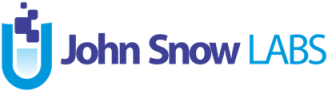

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/tutorials/end-to-end-notebooks/HuggingFace_Real_World_Notebook.ipynb)

**LangTest** is an open-source python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, Spacy** models or **OpenAI, Cohere, AI21, Hugging Face Inference API and Azure-OpenAI** based LLMs, it has got you covered. You can test any Named Entity Recognition (NER), Text Classification, fill-mask, Translation model using the library. We also support testing LLMS for Question-Answering, Summarization and text-generation tasks on benchmark datasets. The library supports 60+ out of the box tests. For a complete list of supported test categories, please refer to the [documentation](http://langtest.org/docs/pages/docs/test_categories).

Metrics are calculated by comparing the model's extractions in the original list of sentences against the extractions carried out in the noisy list of sentences. The original annotated labels are not used at any point, we are simply comparing the model against itself in a 2 settings.

# Getting started with LangTest on Hugging Face

In [ ]:
!pip install langtest["transformers"]

# Initial setup

In [ ]:
! pip install seqeval
! pip install overrides

#Harness and its Parameters

The Harness class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a  NLP model on a given task using test data and generates a report with test results.Harness can be imported from the LangTest library in the following way.

In [3]:
#Import Harness from the LangTest library
from langtest import Harness

It imports the Harness class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and that instances of the Harness class can be customized or configured for different testing scenarios or environments.

Here is a list of the different parameters that can be passed to the Harness function:

<br/>



| Parameter  | Description |  
| - | - | 
|**task**     |Task for which the model is to be evaluated (text-classification or ner)|
| **model**     | Specifies the model(s) to be evaluated. This parameter can be provided as either a dictionary or a list of dictionaries. Each dictionary should contain the following keys: <ul><li>model (mandatory): 	PipelineModel or path to a saved model or pretrained pipeline/model from hub.</li><li>hub (mandatory): Hub (library) to use in back-end for loading model from public models hub or from path</li></ul>|
| **data**      | The data to be used for evaluation. A dictionary providing flexibility and options for data sources. It should include the following keys: <ul><li>data_source (mandatory): The source of the data.</li><li>subset (optional): The subset of the data.</li><li>feature_column (optional): The column containing the features.</li><li>target_column (optional): The column containing the target labels.</li><li>split (optional): The data split to be used.</li><li>source (optional): Set to 'huggingface' when loading Hugging Face dataset.</li></ul> |
| **config**    | Configuration for the tests to be performed, specified in the form of a YAML file. |


<br/>
<br/>

# Real-World Project Workflows

In this section, we dive into complete workflows for using the model testing module in real-world project settings.

## Testing

In this example, we will be testing a model's performance for different specified test types. The real-world project workflow of the model testing and fixing in this case goes as follows:

1. Train NER model on original CoNLL training set

2. Test NER model performance on CoNLL test set

3. Augment CoNLL training set based on test results 

4. Train new NER model on augmented CoNLL training set

5. Test new NER model on the CoNLL test set from step 2

6. Compare the new NER model against original NER model

#### Load Train and Test CoNLL


In [ ]:
# Load test CoNLL
!wget https://raw.githubusercontent.com/JohnSnowLabs/langtest/main/langtest/data/conll/sample.conll

# Load train CoNLL
!wget https://raw.githubusercontent.com/JohnSnowLabs/langtest/main/demo/data/conll03.conll

#### Step 1: Train NER Model

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertForTokenClassification, BertTokenizerFast, Trainer, TrainingArguments
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
file_path = "conll03.conll"

def read_conll_file(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
    return lines

lines = read_conll_file(file_path)

# Preprocess dataset
def preprocess_conll(lines):
    tokens = []
    labels = []
    token_list = []
    label_list = []

    for line in lines:
        if line.startswith("-DOCSTART-") or line == "\n":
            if token_list:
                tokens.append(token_list)
                labels.append(label_list)
            token_list = []
            label_list = []
        else:
            token, _, _, label = line.strip().split()
            token_list.append(token)
            label_list.append(label)

    return tokens, labels

tokens, labels = preprocess_conll(lines)

class NERDataset(Dataset):
    def __init__(self, tokens, labels, tokenizer, max_length=128):
        self.tokens = tokens
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.label_map = {label: i for i, label in enumerate(sorted(set([lbl for doc_labels in labels for lbl in doc_labels])))}
        self.label_map["PAD"] = -100
        self.id2label = {v: k for k, v in self.label_map.items()}

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        token_list = self.tokens[idx]
        label_list = self.labels[idx]

        encoded = self.tokenizer(token_list, is_split_into_words=True, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        token_ids = encoded.input_ids.squeeze(0)
        attention_mask = encoded.attention_mask.squeeze(0)

        label_ids = [self.label_map[label] for label in label_list]
        label_ids = [-100] + label_ids + [-100]  # Account for [CLS] and [SEP] tokens
        label_ids += [-100] * (self.max_length - len(label_ids))  # Pad labels

        return {
            "input_ids": token_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label_ids, dtype=torch.long),
        }

# Initialize tokenizer and dataset
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
train_dataset = NERDataset(tokens, labels, tokenizer)

# Initialize model
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(train_dataset.label_map),
    id2label=train_dataset.id2label,
    label2id=train_dataset.label_map,
    ignore_mismatched_sizes=True,
)

# Initialize the classifier layer with the correct number of labels
model.classifier = torch.nn.Linear(model.config.hidden_size, len(train_dataset.label_map))

# Move the model to the appropriate device
model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=64,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=1000,
    learning_rate=3e-5,
    weight_decay=0.01,
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Step,Training Loss
100,0.603200
200,0.305800
300,0.226300
400,0.185500
500,0.156500


TrainOutput(global_step=510, training_loss=0.2929473337005166, metrics={'train_runtime': 3200.1279, 'train_samples_per_second': 10.156, 'train_steps_per_second': 0.159, 'total_flos': 2123189702400000.0, 'train_loss': 0.2929473337005166, 'epoch': 10.0})

In [6]:
# Save the trained model
tokenizer.save_pretrained("trained_model")
model.save_pretrained("trained_model")

#### Step 2: Test NER Model 

In [7]:

h = Harness(task="ner", model={"model": "trained_model", "hub": "huggingface"}, data={"data_source" :"sample.conll"})

In [8]:
h.configure(
{'tests': {
    'defaults': {'min_pass_rate': 0.65},

    'robustness': {
        'uppercase': {'min_pass_rate': 0.66}, 
        'lowercase':{'min_pass_rate': 0.60},
        'titlecase':{'min_pass_rate': 0.60},
        'strip_punctuation':{'min_pass_rate': 0.60},
        'add_typo':{'min_pass_rate': 0.60},
        'add_contraction':{'min_pass_rate': 0.60},
        'american_to_british':{'min_pass_rate': 0.60},
        'british_to_american':{'min_pass_rate': 0.60},
        'add_context': {'min_pass_rate': 0.65,
            'parameters': {'ending_context': ['Bye', 'Reported'],
              'starting_context': ['Hi', 'Good morning', 'Hello']}} 
      },
    'bias': {
      'replace_to_male_pronouns': {'min_pass_rate': 0.66}, 
      'replace_to_female_pronouns':{'min_pass_rate': 0.60},
      'replace_to_neutral_pronouns':{'min_pass_rate': 0.60},
      'replace_to_high_income_country':{'min_pass_rate': 0.60},
      'replace_to_low_income_country':{'min_pass_rate': 0.60},
      'replace_to_upper_middle_income_country':{'min_pass_rate': 0.60},
      'replace_to_lower_middle_income_country':{'min_pass_rate': 0.60},
      'replace_to_white_firstnames':{'min_pass_rate': 0.60},
      'replace_to_black_firstnames':{'min_pass_rate': 0.60},
      'replace_to_hispanic_firstnames':{'min_pass_rate': 0.60},
      'replace_to_asian_firstnames':{'min_pass_rate': 0.60},
      'replace_to_white_lastnames':{'min_pass_rate': 0.60},
      'replace_to_sikh_names':{'min_pass_rate': 0.60},
      'replace_to_christian_names':{'min_pass_rate': 0.60},
      'replace_to_hindu_names':{'min_pass_rate': 0.60},
      'replace_to_muslim_names':{'min_pass_rate': 0.60},
      'replace_to_asian_lastnames':{'min_pass_rate': 0.60},
      'replace_to_hispanic_lastnames':{'min_pass_rate': 0.60},
      'replace_to_black_lastnames':{'min_pass_rate': 0.60},
      'replace_to_parsi_names':{'min_pass_rate': 0.60},
      'replace_to_jain_names':{'min_pass_rate': 0.60},
      'replace_to_buddhist_names':{'min_pass_rate': 0.60}
    },
    'representation':{
      'min_label_representation_count': {'min_count': 10}                  
    },
    'accuracy': {'min_micro_f1_score':{'min_score': 0.60}
    },       
    'fairness': {'min_gender_f1_score': {'min_score': 0.6}}
    }
  }
 )

{'tests': {'defaults': {'min_pass_rate': 0.65},
  'robustness': {'uppercase': {'min_pass_rate': 0.66},
   'lowercase': {'min_pass_rate': 0.6},
   'titlecase': {'min_pass_rate': 0.6},
   'strip_punctuation': {'min_pass_rate': 0.6},
   'add_typo': {'min_pass_rate': 0.6},
   'add_contraction': {'min_pass_rate': 0.6},
   'american_to_british': {'min_pass_rate': 0.6},
   'british_to_american': {'min_pass_rate': 0.6},
   'add_context': {'min_pass_rate': 0.65,
    'parameters': {'ending_context': ['Bye', 'Reported'],
     'starting_context': ['Hi', 'Good morning', 'Hello']}}},
  'bias': {'replace_to_male_pronouns': {'min_pass_rate': 0.66},
   'replace_to_female_pronouns': {'min_pass_rate': 0.6},
   'replace_to_neutral_pronouns': {'min_pass_rate': 0.6},
   'replace_to_high_income_country': {'min_pass_rate': 0.6},
   'replace_to_low_income_country': {'min_pass_rate': 0.6},
   'replace_to_upper_middle_income_country': {'min_pass_rate': 0.6},
   'replace_to_lower_middle_income_country': {'min_pas

#### Generating the test cases.

In [9]:
h.generate()

Generating testcases... (fairness):  80%|████████  | 4/5 [03:52<00:48, 48.06s/it]

Generating testcases... (fairness): 100%|██████████| 5/5 [04:01<00:00, 48.38s/it]


h.generate() method automatically generates the test cases (based on the provided configuration)

#### Saving test configurations, data, test cases

In [10]:
h.save("saved_harness")

In [11]:
h.run().report()

Running test cases...: 100%|██████████| 7015/7015 [06:14<00:00, 18.74it/s]


,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,uppercase,162,64,28%,66%,False
1,robustness,lowercase,165,61,27%,60%,False
2,robustness,titlecase,100,126,56%,60%,False
3,robustness,strip_punctuation,100,126,56%,60%,False
4,robustness,add_typo,100,126,56%,60%,False
5,robustness,add_contraction,1,225,100%,60%,True
6,robustness,american_to_british,0,226,100%,60%,True
7,robustness,british_to_american,2,224,99%,60%,True
8,robustness,add_context,45,181,80%,65%,True
9,bias,replace_to_male_pronouns,2,224,99%,66%,True


It runs the test cases and summarizes the results giving information about pass and fail counts and overall test pass/fail flag.

####  Step 3: Augment CoNLL training set based on test results.

In [12]:
data_kwargs = {
      "data_source" : "conll03.conll",
       }

h.augment(training_data=data_kwargs, save_data_path="augmented_conll03.conll", export_mode="add")

#### Step 4: Train New NER Model on Augmented CoNLL

In [13]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertForTokenClassification, BertTokenizerFast, Trainer, TrainingArguments
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load augmented CoNLL
file_path = "augmented_conll03.conll"

def read_conll_file(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
    return lines

lines = read_conll_file(file_path)

# Preprocess dataset
def preprocess_conll(lines):
    tokens = []
    labels = []
    token_list = []
    label_list = []

    for line in lines:
        if line.startswith("-DOCSTART-") or line == "\n":
            if token_list:
                tokens.append(token_list)
                labels.append(label_list)
            token_list = []
            label_list = []
        else:
            token, _, _, label = line.strip().split()
            token_list.append(token)
            label_list.append(label)

    return tokens, labels

tokens, labels = preprocess_conll(lines)

class NERDataset(Dataset):
    def __init__(self, tokens, labels, tokenizer, max_length=128):
        self.tokens = tokens
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.label_map = {label: i for i, label in enumerate(sorted(set([lbl for doc_labels in labels for lbl in doc_labels])))}
        self.label_map["PAD"] = -100
        self.id2label = {v: k for k, v in self.label_map.items()}

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        token_list = self.tokens[idx]
        label_list = self.labels[idx]

        encoded = self.tokenizer(token_list, is_split_into_words=True, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        token_ids = encoded.input_ids.squeeze(0)
        attention_mask = encoded.attention_mask.squeeze(0)

        label_ids = [self.label_map[label] for label in label_list]
        label_ids = [-100] + label_ids + [-100]  # Account for [CLS] and [SEP] tokens
        label_ids += [-100] * (self.max_length - len(label_ids))  # Pad labels

        return {
            "input_ids": token_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label_ids, dtype=torch.long),
        }

# Initialize tokenizer and dataset
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
train_dataset = NERDataset(tokens, labels, tokenizer)

# Initialize model
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(train_dataset.label_map),
    id2label=train_dataset.id2label,
    label2id=train_dataset.label_map,
    ignore_mismatched_sizes=True,
)

# Initialize the classifier layer with the correct number of labels
model.classifier = torch.nn.Linear(model.config.hidden_size, len(train_dataset.label_map))

# Move the model to the appropriate device
model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=64,
    logging_dir="./logs",
    logging_steps=100,
    save_steps=1000,
    learning_rate=3e-5,
    weight_decay=0.01,
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6588, 'learning_rate': 2.6103896103896104e-05, 'epoch': 1.3}
{'loss': 0.3913, 'learning_rate': 2.2207792207792207e-05, 'epoch': 2.6}
{'loss': 0.3037, 'learning_rate': 1.831168831168831e-05, 'epoch': 3.9}
{'loss': 0.252, 'learning_rate': 1.4415584415584416e-05, 'epoch': 5.19}
{'loss': 0.2103, 'learning_rate': 1.051948051948052e-05, 'epoch': 6.49}
{'loss': 0.1942, 'learning_rate': 6.6233766233766234e-06, 'epoch': 7.79}
{'loss': 0.1712, 'learning_rate': 2.7272727272727272e-06, 'epoch': 9.09}
{'train_runtime': 4354.5161, 'train_samples_per_second': 11.188, 'train_steps_per_second': 0.177, 'train_loss': 0.29835004806518556, 'epoch': 10.0}


TrainOutput(global_step=770, training_loss=0.29835004806518556, metrics={'train_runtime': 4354.5161, 'train_samples_per_second': 11.188, 'train_steps_per_second': 0.177, 'train_loss': 0.29835004806518556, 'epoch': 10.0})

In [14]:
# Save the new model
tokenizer.save_pretrained("augmented_model")
model.save_pretrained("augmented_model")

### Step 5: Testing new NER Model

### Load saved test configurations, data

In [15]:
# Loading Harness
h_new = Harness.load('saved_harness',
                       model={"model": "augmented_model","hub":"huggingface"},
                       task="ner",                                 
                       load_testcases=True)

Generating testcases... (robustness): 100%|██████████| 5/5 [04:08<00:00, 49.76s/it]


In [16]:
h_new.run().report()

Running test cases...: 100%|██████████| 7015/7015 [05:57<00:00, 19.60it/s]


,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,accuracy,min_micro_f1_score,0,1,100%,65%,True
1,bias,replace_to_asian_firstnames,28,198,88%,60%,True
2,bias,replace_to_asian_lastnames,72,154,68%,60%,True
3,bias,replace_to_black_firstnames,31,195,86%,60%,True
4,bias,replace_to_black_lastnames,75,151,67%,60%,True
5,bias,replace_to_buddhist_names,32,194,86%,60%,True
6,bias,replace_to_christian_names,19,207,92%,60%,True
7,bias,replace_to_female_pronouns,9,217,96%,60%,True
8,bias,replace_to_high_income_country,12,214,95%,60%,True
9,bias,replace_to_hindu_names,30,196,87%,60%,True


It runs the test cases and summarizes the results giving information about pass and fail counts and overall test pass/fail flag.